https://www.kaggle.com/datasets/tunguz/used-car-auction-prices?resource=download

## What
Predict what a car will sell for at Auction given 
features of the car such as make, model, condition, odometer, et cetera.


# Why
Could be useful for buyers so they can guage their bids.
Also useful for sellers to give an idea of what a car is worth at auction.

# Background
I was looking for a decent data set to use for regression and I found this one on Kaggle,   
  see https://www.kaggle.com/datasets/tunguz/used-car-auction-prices?resource=download  

I find auctions fascinating and since the data here comes from real auctions I decided this was a good choice.  
It is also a good one to practice some data manipulation and feature engineering one.


In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

In [ ]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  source_dir = '/content/gdrive/MyDrive/data/'
  os.listdir(source_dir)
else:
  source_dir = "."
fpath = os.path.join(source_dir, "car_prices.csv")
orig = pd.read_csv(fpath, on_bad_lines="skip" )
orig.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(558811, 16)

In [ ]:
""" Some functions to compile a "summary" of a data frame
    including types, number unique, min and max """

def getTypes(df):
    serlist  = []
    temp = df.applymap(type)
    for col in temp.columns:
        ser = pd.Series(name=col, dtype="float32")
        ser[col] = temp[col].unique()
        serlist.append(ser)
    ser = pd.concat(serlist)
    ser.name = "dtypes"
    return ser

def getMinMax(df):
    minser = pd.Series(name="min", dtype="float32")
    maxser = pd.Series(name="max", dtype="float32")
    for col in df.columns:
        try:
            minser[col] = df.loc[df[col].notnull(), col].min()
            maxser[col] = df.loc[df[col].notnull(), col].max()
        except:
            minser[col] = None
            maxser[col] = None
    res = pd.merge(minser, maxser, left_index=True, right_index=True)
    return res

def dfSummary(df):
    sdf = pd.DataFrame(df.isnull().sum(), columns=["nulls"])
    temp = pd.DataFrame(getTypes(df), columns=["dtypes"])
    sdf = sdf.merge(temp, how="left", left_index=True, right_index=True)
    temp = pd.DataFrame(df.nunique(), columns=["nunique"])
    sdf = sdf.merge(temp, how="left", left_index=True, right_index=True)
    sdf = sdf.merge(getMinMax(df), how="left", left_index=True, right_index=True)    
    return sdf

In [ ]:
dfSummary(orig)

,nulls,dtypes,nunique,min,max
year,0,[<class 'int'>],34,1982,2015
make,10301,"[<class 'str'>, <class 'float'>]",96,Acura,vw
model,10399,"[<class 'str'>, <class 'float'>]",973,1,yukon
trim,10651,"[<class 'str'>, <class 'float'>]",1975,!,zx3
body,13195,"[<class 'str'>, <class 'float'>]",86,Access Cab,xtracab
transmission,65353,"[<class 'str'>, <class 'float'>]",2,automatic,manual
vin,0,[<class 'str'>],550296,137fa90362e197965,zhwgu22t97la05738
state,0,[<class 'str'>],38,ab,wi
condition,11794,[<class 'float'>],41,1.0,5.0
odometer,94,[<class 'float'>],172277,1.0,999999.0


### Observations on original data
- there are a lot of nulls, but still relatively small
   in comparison to the half a million records
- some columns have string and float, probably np.nan values
- some of the categorical variables have a large number of 
    different values, maybe too many for one-hot encoding. 
    Here I am thinking mainly of Model which I expect
    could be a useful feature
- looks like there are some bad values in some columns,
 e.g. Min for Model is 1.

### Drop nulls
Lets try dropping all rows with null values and see what we have left.


In [ ]:
nn = orig.dropna().copy()
nn.shape

(472336, 16)

Still over 450,000 records.  That might be enough for a model.
At some point it might be worth some analysis of the distribution
of the records with null values, but not now.

In [ ]:
""" add a few columns
 - a real date column from the string date and show summary again
 - age, from the selldt and year
 - logmileage, maybe mileage is not linear itself but some transform is
 - intcondition, since condition takes on many values between 1 and 5
                I wanted to just have 5 values.
 """
nn["selldt"] = pd.to_datetime(orig["saledate"])
nn["age"] = nn.selldt.apply(lambda x: x.year) - nn.year
nn['logmileage'] = nn.odometer.apply(lambda x: int(np.ceil(np.log(x))))
nn["intcondition"] = nn.condition.apply(lambda x: int(np.ceil(x)*10))
# redo the summary after dropping nulls and adding columns
dfSummary(nn)

,nulls,dtypes,nunique,min,max
year,0,[<class 'int'>],26,1990,2015
make,0,[<class 'str'>],53,Acura,smart
model,0,[<class 'str'>],768,1 Series,xD
trim,0,[<class 'str'>],1507,!,xDrive50i
body,0,[<class 'str'>],85,Access Cab,xtracab
transmission,0,[<class 'str'>],2,automatic,manual
vin,0,[<class 'str'>],465779,137za84341e193591,zhwgu22t97la05738
state,0,[<class 'str'>],34,al,wi
condition,0,[<class 'float'>],41,1.0,5.0
odometer,0,[<class 'float'>],160427,1.0,999999.0


After dropping nulls, no more multiple types in a column, so they were nan's

Note the -1 in age.  That might not be a bad value since 2015 cars start selling in 2014.

Note that the selling price ranges from 1 to over 200K.  These extremes seem like outliers that we can filter out.
Let's look at some of the extreme percentiles for sellingprice and a few other columns.

In [ ]:
cols = ["sellingprice", "odometer", "age"]
for col in cols:
  print(col)
  display(nn[col].quantile([.01, .05, 0.95, .99]))
  print("---")

sellingprice


0.01      500.0
0.05     1650.0
0.95    30500.0
0.99    44500.0
Name: sellingprice, dtype: float64

---
odometer


0.01      3344.05
0.05     10450.00
0.95    165554.25
0.99    221144.95
Name: odometer, dtype: float64

---
age


0.01     0.0
0.05     1.0
0.95    12.0
0.99    16.0
Name: age, dtype: float64

---


Given the quantiles above I will filter out
sellingprice, odometer and age.
I will choose some round numbers based on the data above.

In [ ]:
nn_filtered = nn.copy()
nn_filtered = nn.loc[(nn_filtered.sellingprice >= 1000) & (nn_filtered.sellingprice <= 30000)]
nn_filtered = nn.loc[(nn_filtered.odometer >= 3000) & (nn_filtered.odometer <= 200000)]
nn_filtered = nn.loc[(nn_filtered.age >= 0) & (nn_filtered.age <= 12)]

Also, I want to make condition, age and logmileage factors

In [ ]:

nn_cat = nn_filtered.copy()
for col in ["intcondition", "logmileage", "age"]:
  nn_cat[col] = nn_cat[col].astype('category')

My gut sense is that the following numeric columns seem useful
- age, intcondition and logmileage.
mmr is some value provided by one of the auction houses.
I am not sure when it is available so not sure if we can use it.

Let's look at some plots of these variables

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

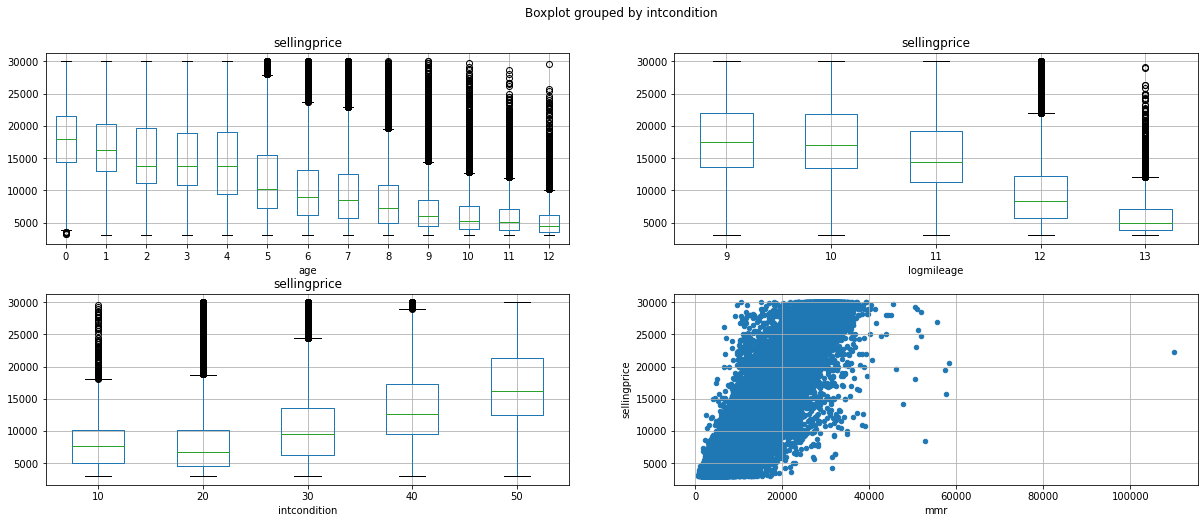

In [ ]:
cols = ["age",  "logmileage", "intcondition", "mmr"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[20,8])
fig.tight_layout(h_pad=4)
for i, col in enumerate(cols):
  r = i // 2
  c = i % 2
  ax = axs[r, c]
  ax.set_ylabel("")
  if col == "mmr":
    nn_cat.plot.scatter(ax=ax, x=col, y="sellingprice", grid=True) 
    continue 
  nn_cat.boxplot(ax=ax, column="sellingprice", by=col, grid=True)

The relationships are somewhat as expected
- older cars tend to sell for less, although 2, 3 and 4 years
   seem to be about the same
- more mileage generally means lower price,
       but only after the log is larger than 10
- better condition generally means higher price
   but there seems to be little difference between 
    condition 1 and 2

The mmr value seems to track sellingprice fairly well, 
  so it is probably the result of some model on 
  the given features and perhaps more.

In summary, age, intcondition and logmileage seem good, 
  and mmr seems almost too good.

For the categorical columns
- transmission: create a new column "automatic"
- make, color, interior: make dummies
- model: I think it is important but too many for
     dummies.  I will use target encoding

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77]),
 <a list of 77 Text major ticklabel objects>)

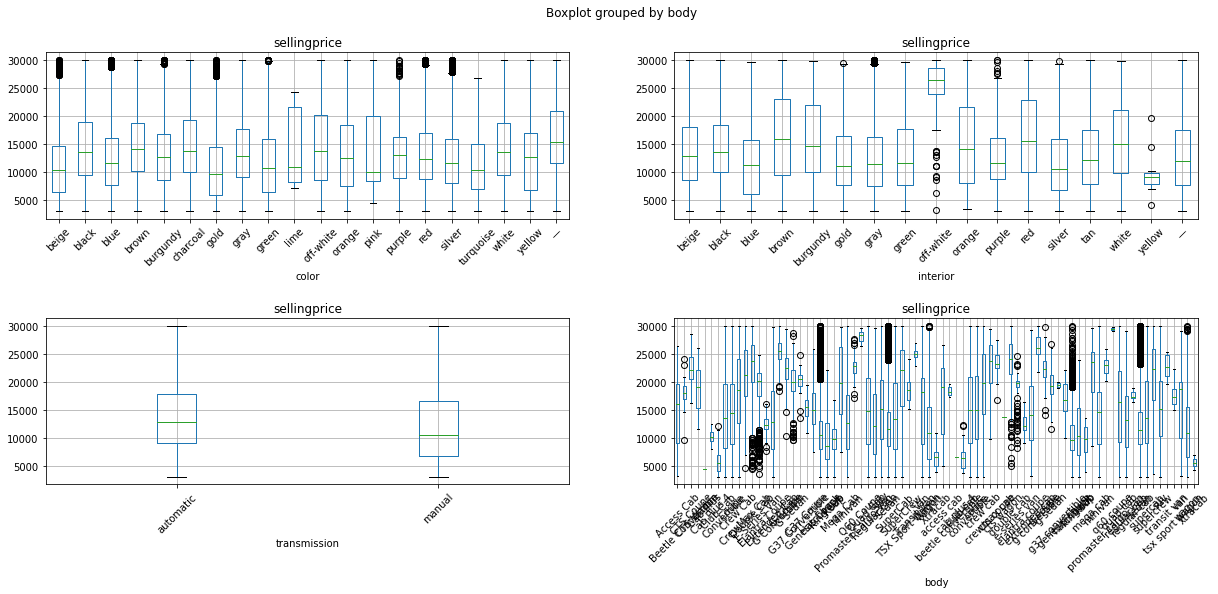

In [ ]:
cols = ["color", "interior", "transmission"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[20,8])
plt.xticks(rotation = 45) 
fig.tight_layout(h_pad=10)
for i, col in enumerate(cols):
  r = i // 2
  c = i % 2
  ax = axs[r, c]
  ax.set_ylabel("")
  nn_cat.boxplot(ax=ax, column="sellingprice", by=col, grid=True)
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)  
plt.xticks(rotation = 45) 


There are too many body types for me to make much sense of it.
However, if I were planning to bid myself I might dig deeper there.

I don't see anything in particular to use in color or transmission.
With interior, it seems that it might be worth having a variable
for whether it is off-white or not.

In [ ]:
nn_cat["off_white"] = nn.interior.apply(lambda x: int(x=="off-white"))

### Make and Model
What to do with make and model which certainly will affect the sellingprice.  I think there are too many models to use one-hot encoding to make it a factor, but I also don't think make is enough ... I tried it.
So one possible way to procede is to build a different model for each make.  I think a given make has a manageable number of models so this seems like a good approach, especially for a seller who might have only one or a few make or a buyer who is only interested in a few makes.


In [ ]:
data = nn_cat[nn_cat.make == "Toyota"].copy()

In [ ]:
cat_cols = ["model", "intcondition", "logmileage", "age"]
for ccol in cat_cols:
  dummies = pd.get_dummies(data[ccol])
  dummies.columns = [f"{ccol}__{x}" for x in dummies.columns]
  data = pd.concat([data, dummies], axis=1)

Target encoding for model, i.e. create a new variable with the mean selling price of each model.

In [ ]:
dummy_cols = [x for x in  data.columns if "_" in x] + ["off_white"]
num_cols = ["condition", "odometer", ]
xcols = num_cols + dummy_cols
ycol = "sellingprice"
X = data[xcols]
y = data[ycol]

In [ ]:
print(X.shape, y.shape)

(31437, 53) (31437,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
regr = RandomForestRegressor(max_depth=3, n_estimators=300, random_state=0)
regr = GradientBoostingRegressor(n_estimators=300)
regr.fit(X, y)

GradientBoostingRegressor(n_estimators=300)

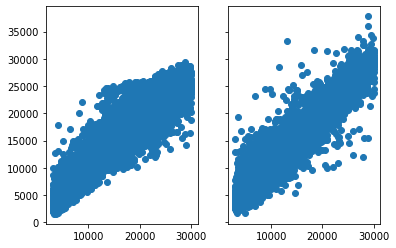

In [ ]:
ypred = regr.predict(X)
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
data["ypred"] = ypred
ax[0].scatter(y, ypred)
ax[1].scatter(y, data.mmr)

In [ ]:
myrmse = np.sqrt(np.mean((y - ypred)**2))
mmrmse = np.sqrt(np.mean((y - data.mmr)**2))
print(f"{myrmse}  {mmrmse} ")

1785.6516403987464  1405.466398838191 


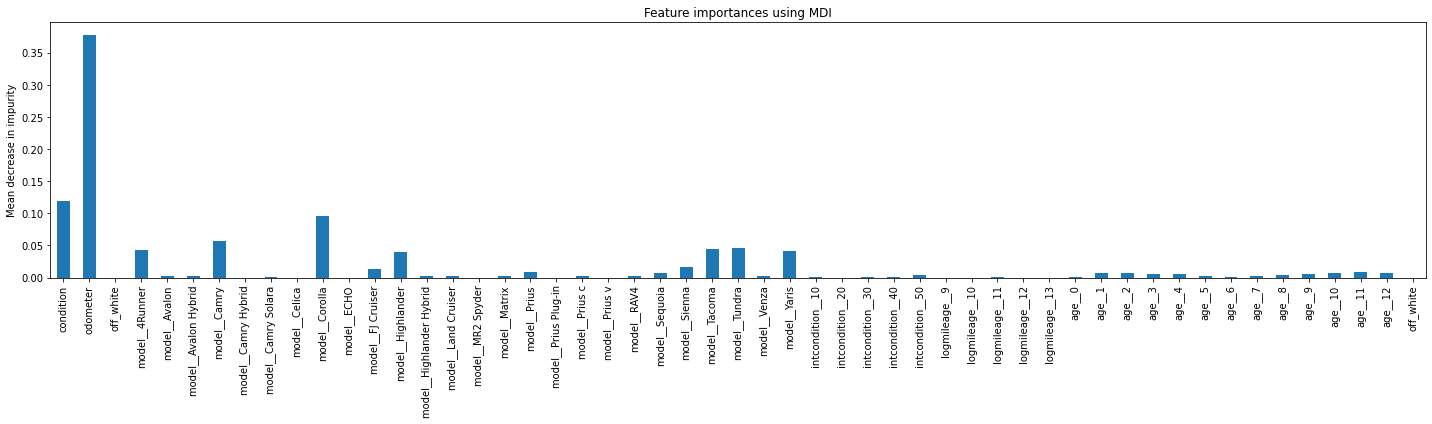

In [ ]:
import pandas as pd
import time
import numpy as np

start_time = time.time()
importances = regr.feature_importances_
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
elapsed_time = time.time() - start_time
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=[20,6])
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [ ]:
X.head()

,condition,odometer,age,interior__beige,interior__black,interior__blue,interior__brown,interior__burgundy,interior__gold,interior__gray,interior__green,interior__orange,interior__purple,interior__red,interior__silver,interior__tan,interior__white,interior__—,automatic
5,1.0,5554.0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True
15,2.0,11398.0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True
53,1.0,4314.0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True
62,3.9,1608.0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False
69,2.0,5773.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True
